In [1]:
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from scipy import special, stats, optimize, linalg
import math
from tqdm import tqdm

import time

### Najprej dejmo genererat pa diagonalizerat neki random matrik

Dejmo najprej implementerat generacijske funkcije za matrike (pac q_ij)

In [2]:
def delta(a,b):
    return 1 if a == b else 0

def q_ij(i,j):
    return 1/2 * np.sqrt(i+j+1) * delta(np.abs(i-j),1)

def q_ij_2(i,j):
    return 1/2 * ( np.sqrt(j*(j-1))*delta(i,j-2) + (2*j+1)*delta(i,j) + np.sqrt((j+1)*(j+2))*delta(i,j+2) )

def q_ij_4(i,j):
    return 1/2**4 * np.sqrt((2**i * math.factorial(i))/(2**j * math.factorial(j))) * \
        ( delta(i,j+4) + 4*(2*j+3)*delta(i,j+2) + 12*(2*j**2 + 2*j + 1)*delta(i,j) + \
            16*j*(2*j**2 - 3*j + 1)*delta(i,j-2) + 16*j*(j**3 - 6*j**2 + 11*j - 6)*delta(i,j-4) )

Kar je treba najprej storiti, je seveda implementacija vseh generacijskih funkcij za matrike. Trivialno vendar je pomembno je, če implementiramo v \texttt{Pythonu}, da matrike na potenciramo na navaden Pythonista način (**4), vendar uporabimo funkcijo \texttt{linalg.matrix_power} (zgolj komentar na napako, ki mi je vzela dobro uro!).

In [3]:
def gen_mat_N(func, N):
    i,j = np.indices((N,N))
    func = np.vectorize(func)
    return func(i,j)

In [4]:
def H_0(N):
    return np.identity(N) * 1/2 + np.diag(np.arange(N))


def H(func, exponent, N, delta):
    q_4 = gen_mat_N(func, N)
    H = H_0(N) + delta * np.linalg.matrix_power(q_4,exponent)
    return H

In [5]:
def make_plot(func, exponent, N, delta):
    return linalg.eigh(H)

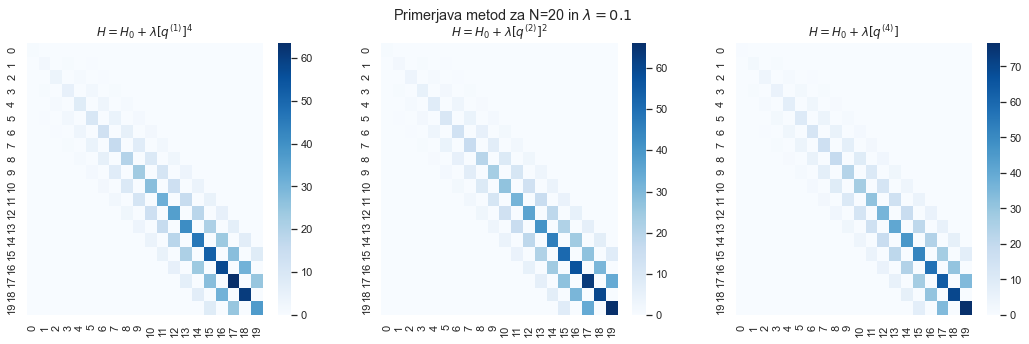

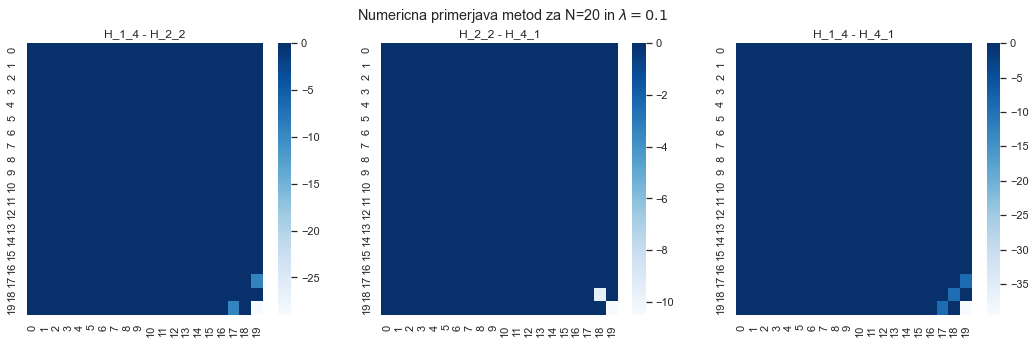

In [6]:
def compare_first_H(N,lambda_param):
    H_1_4 = H(q_ij, 4, N, lambda_param)
    H_2_2 = H(q_ij_2, 2, N, lambda_param)
    H_4_1 = H(q_ij_4, 1, N, lambda_param)

    fig = plt.figure()
    fig.suptitle(f"Primerjava metod za N={N} in $\lambda={lambda_param}$")
    fig.set_size_inches(18,5)
    ax1 = fig.add_subplot(131)
    ax1.set_title("$H = H_0 + \lambda [q^{(1)}]^4$")
    ax2 = fig.add_subplot(132)
    ax2.set_title("$H = H_0 + \lambda [q^{(2)}]^2$")
    ax3 = fig.add_subplot(133)
    ax3.set_title("$H = H_0 + \lambda [q^{(4)}]$")

    sns.heatmap(H_1_4, cmap='Blues',ax=ax1)
    sns.heatmap(H_2_2, cmap='Blues',ax=ax2)
    sns.heatmap(H_4_1, cmap='Blues',ax=ax3)
    plt.savefig('./grafi/matrike_qij.pdf', bbox_inches='tight')
    plt.show()

    fig = plt.figure()
    fig.suptitle(f"Numericna primerjava metod za N={N} in $\lambda={lambda_param}$")
    fig.set_size_inches(18, 5)
    ax1 = fig.add_subplot(131)
    ax1.set_title("H_1_4 - H_2_2")
    ax2 = fig.add_subplot(132)
    ax2.set_title("H_2_2 - H_4_1")
    ax3 = fig.add_subplot(133)
    ax3.set_title("H_1_4 - H_4_1")

    sns.heatmap(H_1_4 - H_2_2, cmap='Blues', ax=ax1)
    sns.heatmap(H_2_2 - H_4_1, cmap='Blues', ax=ax2)
    sns.heatmap(H_1_4 - H_4_1, cmap='Blues', ax=ax3)
    plt.savefig('./grafi/matrike_qij_razlike.pdf', bbox_inches='tight')
    plt.show()


compare_first_H(20,0.1)


Ko generiramo matrike za vse tri možnosti, je dobro vprašanje katera metoda je zares najboljša za diagonalizacijo.
Izkaže se (kot je vidno na grafih), da so vse vrednost zelo blizu, razen desno spodaj (pri velikih vrednostih matrike). Kar lahko storimo je, da zgeneriramo matriko, ki je malce večja kot naša priljubljena dimenzija, ki jo hočemo diagonalizirati oziroma dobiti lastne vektorje. Po tem postopku se zares znebimo razlik med različnimi generacijskimi funkcijami, ker so matrike po vseh treh postokih enake. Časovna zahtevnost generacij matrik (ki je v tem primeru popolnoma zanemarljiva, zaradi kasnejših korakov) je najbolj učinkovita pri primeru $[q^{(4)}]$, ker nimamo nobenih množenj matrik (množenje matrik ima zahtevnost $n^2$, kar za zelo velike matrike lahko pomeni težave).

## Primerjava metod

In [7]:
def cmp(a,b):
    if a<b:
        return -1
    elif a==b:
        return 0
    return 1

def householder(A,cutoff=1e-6):
    M = np.shape(A)[0]
    R = A.copy()
    Q = np.eye(M, M)
    for k in range(M):
        x = R[k:M, k].copy()
        e = np.zeros(len(x))
        e[0] = 1.0
        u = cmp(x[0],0) * np.linalg.norm(x, 2) * e + x
        u = u / np.linalg.norm(u, 2)
        u_t = u.reshape((1, len(u)))
        u = u.reshape(len(u), 1)
        I = np.eye(len(u), len(u))
        F = I - 2.0 * np.dot(u, u_t)
        Q_k = np.eye(M, M)
        Q_k[k:, k:] = F
        Q = np.dot(Q, Q_k)
        for j in range(k, M):
            utA = np.dot(u.T, R[k:, j])
            R[k:, j] = R[k:, j] - 2.0 * np.dot(u, utA)

    # R[R<cutoff] = 0
    return Q, R

# numericne ...
def givens(A):
    M,N = np.shape(A)
    Q = np.eye(M)
    korakov = np.min([N,M-1])
    for j in range(korakov):
        for i in range(j+1,M):
            if not A[i,j] == 0:
                r = np.sqrt(A[j,j]**2 + A[i,j]**2)
                c=A[j,j]/r
                s=A[i,j]/r
                rot = np.array([[c,s],[-s,c]])
                A[[j, i], j:] = np.matmul(rot,A[[j, i], j:])
                Q[[j, i], :] = np.matmul(rot, Q[[j, i], :])
    R = linalg.triu(A)
    return Q.T, R


def qr_iteration_givens(A, iter):
    A = A.copy()
    N,M = np.shape(A)
    Q_total = np.eye(N,M)
    for i in range(iter):
        Q, R = givens(A)
        A = np.dot(R, Q)
        Q_total = np.dot(Q_total, Q)

    return np.diag(A), Q_total


def qr_iteration_householder(A, iter):
    A = A.copy()
    N, M = np.shape(A)
    Q_total = np.eye(N, M)
    for i in range(iter):
        Q, R = householder(A)
        A = np.dot(R, Q)
        Q_total = np.dot(Q_total, Q)

    return np.diag(A), Q_total


## Metode QR dekompozicij

Sedaj lahko implementiramo tudi svoje algoritme za diagonalizacijo matrik oziroma izračun lastnih vektorjev. Pričakovano, se izkaže, da je vgrajena funkcija najbolj časovno učinkovita, ker je implementirana v C.

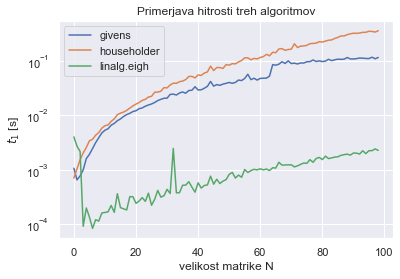

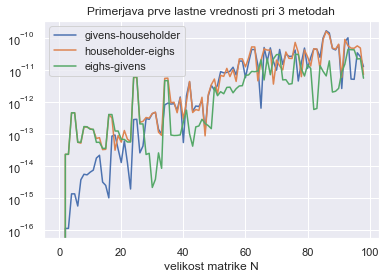

In [8]:
def compare_eigenvalues_iterations(N):
    giv_times = []
    house_times = []
    eigh_times = []

    giv_eigs = []
    house_eigs = []
    eigh_eigs = []

    for n in range(1,N):
        H_n = H(q_ij_4, 2, n, 0.01)
        start = time.time()
        eig_giv = np.sort(qr_iteration_givens(H_n, 10)[0])
        giv_times.append(time.time() - start)
        giv_eigs.append(np.sort(eig_giv)[0])
        
        start = time.time()
        eig_house = np.sort(qr_iteration_householder(H_n, 10)[0])
        house_times.append(time.time() - start)
        house_eigs.append(np.sort(eig_house)[0])

        start = time.time()
        eigh = linalg.eigh(H_n)[0]
        eigh_times.append(time.time() - start)
        eigh_eigs.append(np.sort(eigh)[0])

    
    plt.plot(giv_times, label='givens')
    plt.plot(house_times, label='householder')
    plt.plot(eigh_times, label='linalg.eigh')

    plt.legend()
    plt.yscale("log")
    plt.ylabel("$t_1$ [s]")
    plt.xlabel("velikost matrike N")
    plt.title("Primerjava hitrosti treh algoritmov")
    plt.savefig('./grafi/hitrosti_algoritmi.pdf', bbox_inches='tight')
    plt.show()

    giv_eigs = np.array(giv_eigs)
    house_eigs = np.array(house_eigs)
    eigh_eigs = np.array(eigh_eigs)
    plt.plot(np.abs(giv_eigs-house_eigs),label='givens-householder')
    plt.plot(np.abs(house_eigs-eigh_eigs),label='householder-eighs')
    plt.plot(np.abs(eigh_eigs-giv_eigs),label='eighs-givens')

    plt.yscale('log')
    plt.legend()
    plt.xlabel("velikost matrike N")
    plt.title('Primerjava prve lastne vrednosti pri 3 metodah')
    plt.savefig('./grafi/eigvalue_metode.pdf', bbox_inches='tight')
    plt.plot()
    
compare_eigenvalues_iterations(100)


Kot je vidno na grafu, je vgrajena metoda superiorna na celotnem območju velikosti matrik $N$. Kar je skupno vsem algoritmom je, da časovna zahtevnost narašča z $O(n^3)$. Pri moji implementaciji, je Givensova metoda kar precej hitrejša (ordinata je v logaritemski skali). Sklepam, da taka razlika nastane zaradi večjega števila posameznih korakov, ki jih storim pri Householderjevi metodi. Katera metoda je boljša, se verjetno pokaže na specialnih primerih matrik, ki pa v mojem primeru ne nastopajo. Zato lahko zaključim, da je za primer iskanja lastnih vektorjev in vrednosti pri tej nalogi precej boljša Givensov algoritem.


Lastne vrednosti, ki jih metode izračunajo so enake. Na grafu je primerjava med lastnimi vrednostmi s posameznimi metodami. Opazimo lahko, da so zelo blizu ter to ni več napaka metod, vendar čisto numerična napaka pri računanju (kar pomeni, da bi z več koraki lahko dobili še večjo natančnost).

Mogoce je primerjava mal weird ampak naredu sm tko da dve matrike pac po elementih absolutne vrednosti razlike absolutnih clenov primerjas (pac ce sta lih obratna, je najbol narobe ampak sej to point)...

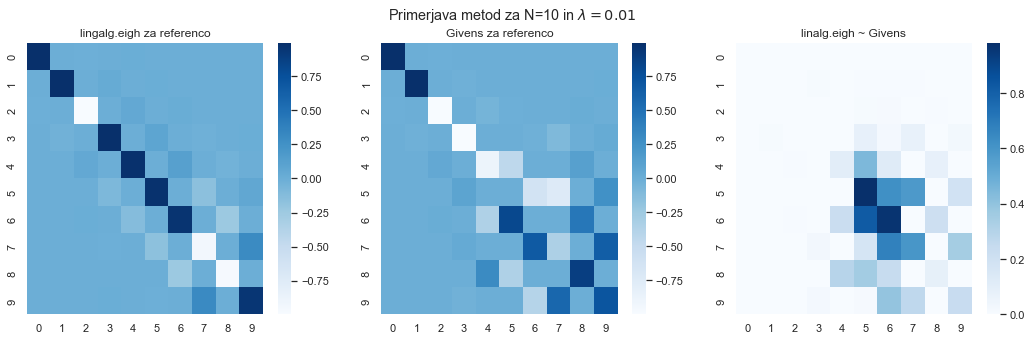

In [9]:
def compare_abs_abs(x,y):
    return np.abs(np.abs(x) - np.abs(y))
compare_abs_abs = np.vectorize(compare_abs_abs)

# N, lambda_param = 10, 0.1

# H_n = H(q_ij, 4, N, lambda_param)
# fig = plt.figure()
# fig.set_size_inches((10,5))
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)



# eigvalues, eigvectors = qr_iteration_givens(H_n, 10)
# eighvalues, eighvectors = linalg.eigh(H_n)

# sort_row = np.argsort(eigvalues)
# eigvectors[:] = eigvectors[:, sort_row]

# sns.heatmap(eigvectors, cmap='Blues', ax=ax1)
# sns.heatmap(eighvectors, cmap='Blues', ax=ax2)
# plt.show()




# tole je ful narobe -> poprau da dejansko tvoje metode vn daje lastne vektorje in vrednosti
def compare_methods(N, lambda_param):
    H_n = H(q_ij, 4, N, lambda_param)
    Q_builtin = linalg.eigh(H_n)[1]

    eigs, Q_h = qr_iteration_householder(H_n, 10)
    Q_givens = qr_iteration_givens(H_n, 10)[1]


    sortby = np.argsort(eigs)
    Q_h[:] = Q_h[:, sortby]
    Q_givens[:] = Q_givens[:, sortby]

    fig = plt.figure()
    fig.suptitle(f"Primerjava metod za N={N} in $\lambda={lambda_param}$")
    fig.set_size_inches(18, 5)
    ax1 = fig.add_subplot(131)
    ax1.set_title("lingalg.eigh za referenco")
    ax2 = fig.add_subplot(132)
    ax2.set_title("Givens za referenco")
    ax3 = fig.add_subplot(133)
    ax3.set_title("linalg.eigh ~ Givens")

    sns.heatmap(Q_builtin, cmap='Blues', ax=ax1)
    sns.heatmap(Q_givens, cmap='Blues', ax=ax2)
    sns.heatmap(compare_abs_abs(Q_builtin, Q_givens), cmap='Blues', ax=ax3)
    plt.savefig('./grafi/primerjava_eigenvectors.pdf', bbox_inches='tight')
    plt.show()

compare_methods(10, 0.01)


Opazimo lahko, da čeprav so lastne vrednosti zelo podobne (v tem primeru praktično enake do zelo velika natančnosti), se lastni vektorji precej razlikujejo. Mera, ki sem jo narisal je zgolj, absolutna razlika med absolutnima vrednostma dveh istoležečih celic.

## Lahko narisem zdej mal grafov za dejanske lastne vrednosti

Od zdaj naprej lahko zaradi hitrosti uporabljam le še vgrajeno funkcijo.

In [10]:
def visualize_eigenvalues(N, M,lambda_param):
    H_n = H(q_ij, 4, N, lambda_param)
    Q_n = linalg.eigh(H_n)[1]

    H_m = H(q_ij, 4, M, lambda_param)
    Q_m = linalg.eigh(H_m)[1]

    fig = plt.figure()
    fig.suptitle(f"Nekaj vizualizacij lastnih vektorjev za $\lambda ={lambda_param}$")
    fig.set_size_inches(18, 5)
    ax1 = fig.add_subplot(131)
    ax1.set_title(f"M = {M}")
    ax2 = fig.add_subplot(132)
    ax2.set_title(f"N = {N}")
    ax3 = fig.add_subplot(133)
    ax3.set_title(f"Razlika prvih {M} vrednosti po obeh izračunih")

    mat = compare_abs_abs(Q_n[:M,:M], Q_m)

    sns.heatmap(Q_n, cmap='Blues', ax=ax2)
    sns.heatmap(Q_m, cmap='Blues', ax=ax1)
    sns.heatmap(mat, cmap='Blues', ax=ax3)
    plt.savefig(f'./grafi/eigenvectors_{N}_{M}_{lambda_param}.pdf', bbox_inches='tight')
    plt.show()


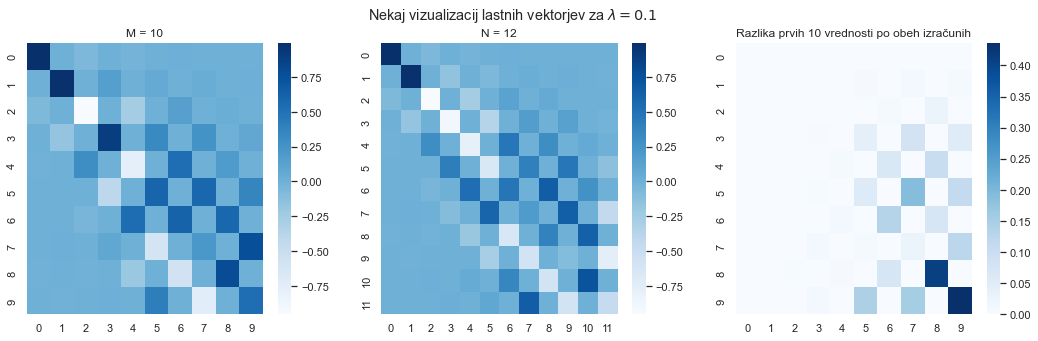

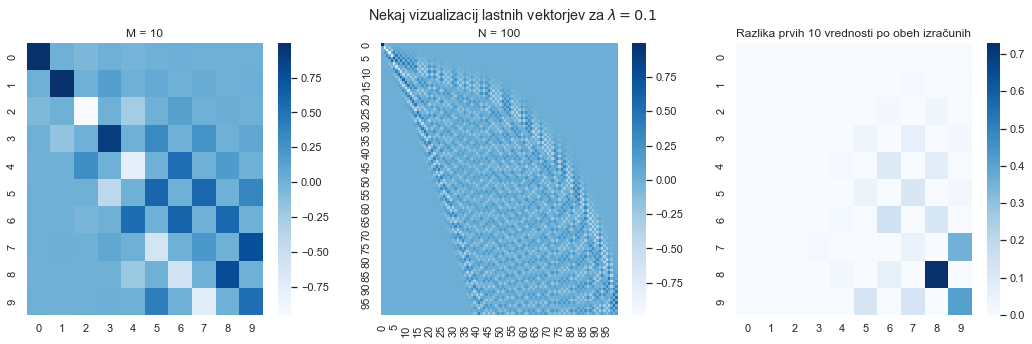

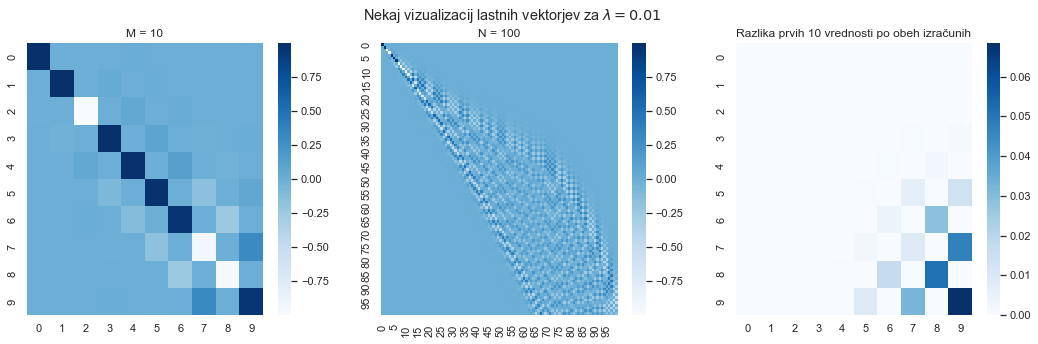

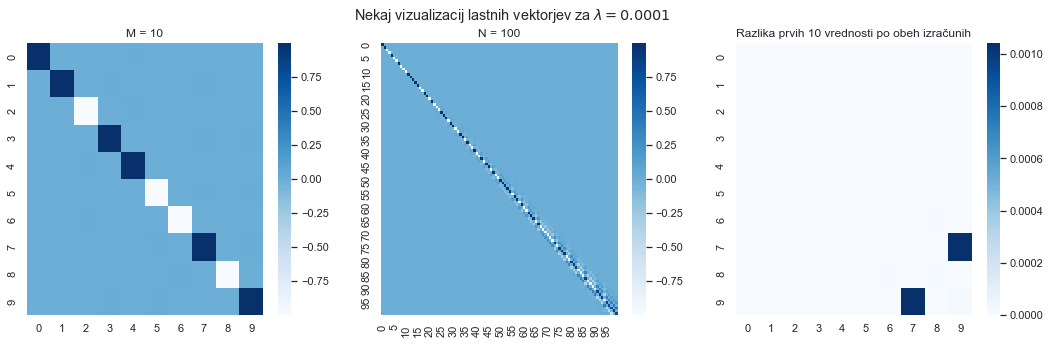

In [11]:
visualize_eigenvalues(12,10,0.1)
visualize_eigenvalues(100,10,0.1)
visualize_eigenvalues(100,10,0.01)
visualize_eigenvalues(100,10,0.0001)

Iz grafov zgoraj lahko opazimo, da lastni vektorji zares konvergirajo proti $E_n^0$, kar je seveda v skladu s teorijo. To, da so nekatere vrednosti po diagonali negativne, nima pravzaprav nobenega fizikalnega ozadja, vendar je samo posledica algoritma. Kar je važno je, da so vektorji med seboj ortogonalni.

Lastni vektorji pri velikih vrednostih $N$ postanejo precej kaotični, vendar se pri majhnih vrednostih $\lambda$ približujejo diagonalni matriki.

Iz grafov tudi lahko opazimo razliko med matriko izračunano direktno z majhno vrednostjo $N = M$,ki jo primerjamo z matriko, ki jo izračunamo z veliko vrednostjo $N$ in skrčimo na $M$. Bolj pravilna matrika je seveda velika matrika, ki jo skrčimo ker bi morali v teoriji vzeti neskončno veliko matriko ter no nato diagonalizirati. Ta analiza je zanimiva, ker nam pokaže, da tudi veliki členi vplivajo na vrednost lastne vektorje pri majhnih $n$.

Se lastne vrednosti

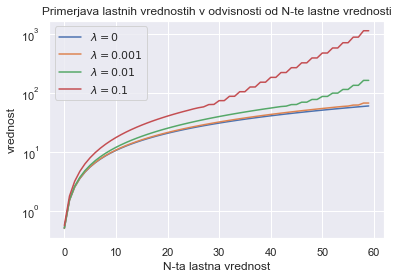

In [12]:
lambdas = [0, 0.001, 0.01, 0.1]

for lam in lambdas:
    H_n = H(q_ij, 4, 60, lam)
    eigvals = linalg.eigh(H_n)[0]

    plt.plot(eigvals, label=f'$\lambda = {lam}$')
plt.xlabel("N-ta lastna vrednost")
plt.ylabel("vrednost")

plt.yscale("log")
plt.legend()
plt.title("Primerjava lastnih vrednostih v odvisnosti od N-te lastne vrednosti")
plt.savefig(f'./grafi/lastne_vrednosti.pdf', bbox_inches='tight')
plt.show()


[0.5 1.5 2.5 3.5 4.5]


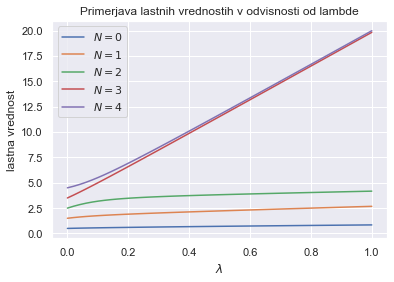

[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


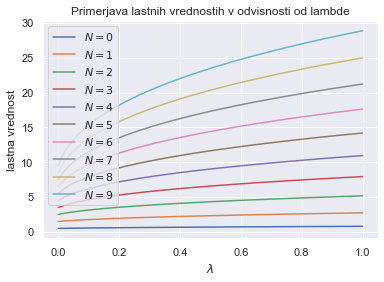

In [13]:
def draw_lastne_lambda(n, N):

    lambdas = np.linspace(0,1)
    y = np.zeros((len(lambdas), n))

    for i in range(len(lambdas)):
        H_n = H(q_ij, 4, N, lambdas[i])
        eigvals = linalg.eigh(H_n)[0][:n]
        y[i] = eigvals

    print(y[0,:])

    for i in range(len(y[0, :])):
        plt.plot(lambdas, y[:, i], label=fr'$N = {i}$')

    plt.xlabel("$\lambda$")
    plt.ylabel("lastna vrednost")

    # plt.yscale("log")
    plt.legend()
    plt.title("Primerjava lastnih vrednostih v odvisnosti od lambde")
    plt.savefig(f'./grafi/lastne_vrednosti_lambda_{n}_{N}.pdf', bbox_inches='tight')
    plt.show()


draw_lastne_lambda(5,5)
draw_lastne_lambda(10,50)

In [14]:
np.zeros([2,3])

array([[0., 0., 0.],
       [0., 0., 0.]])